In [1]:
%load_ext autoreload
%autoreload 2

from dataloader import SignalDataloader
from pathlib import Path
import torch
from ml4gw.gw import compute_observed_strain, get_ifo_geometry
from ml4gw.transforms import SpectralDensity, Whiten
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import lightning.pytorch as pl
import yaml

device = torch.device('cuda')

In [2]:
data_dir = "/home/katya.govorkova/gwak2_background"
sample_rate = 2048
kernel_length = 0.09765625
psd_length = 64
fduration = 1
fftlength = 2
batch_size = 256
batches_per_epoch = 10
num_workers = 2
data_saving_file = Path("../output/test.h5")
duration = fduration + kernel_length

from gwak.data.prior import SineGaussianBBC, LAL_BBHPrior, GaussianBBC, CuspBBC, KinkBBC, KinkkinkBBC, WhiteNoiseBurstBBC
from ml4gw.waveforms import SineGaussian, IMRPhenomPv2, Gaussian, GenerateString, WhiteNoiseBurst

signal_classes = [
    "SineGaussian",
    "BBH",
    "Gaussian",
    "Cusp",
    "Kink",
    "KinkKink",
    "WhiteNoiseBurst"
]
priors = [
    SineGaussianBBC(),
    LAL_BBHPrior(),
    GaussianBBC(),
    CuspBBC(),
    KinkBBC(),
    KinkkinkBBC(),
    WhiteNoiseBurstBBC()
]
waveforms = [
    SineGaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    IMRPhenomPv2(),
    Gaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    WhiteNoiseBurst(
        sample_rate=sample_rate,
        duration=duration
    )
]
extra_kwargs = [
    None,
    {"ringdown_duration":0.9},
    None,
    None,
    None,
    None,
    None
]

In [3]:
loader = SignalDataloader(signal_classes,
    priors,
    waveforms,
    extra_kwargs,
    data_dir=data_dir,
    sample_rate=sample_rate,
    kernel_length=kernel_length,
    psd_length=psd_length,
    fduration=fduration,
    fftlength=fftlength,
    batch_size=batch_size,
    batches_per_epoch=batches_per_epoch,
    num_workers=num_workers,
    data_saving_file=data_saving_file
)

None True
{'ringdown_duration': 0.9} False
None True
None True
None True
None True
None True


In [4]:
test_loader = loader.test_dataloader()

In [5]:
from models import Tarantula
import yaml

ckpt = "../output/SimCLR_multiSignal_all_v1/lightning_logs/y0j0iz3j/checkpoints/48-490.ckpt"
cfg_path = "../output/SimCLR_multiSignal_all_v1/config.yaml"
with open(cfg_path,"r") as fin:
    cfg = yaml.load(fin,yaml.FullLoader)

model = Tarantula.load_from_checkpoint(ckpt,**cfg['model']['init_args'])

/home/katya.govorkova/miniconda3/envs/gwak/lib/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [6]:
from models import Linear
# Load first model (frozen for inference)
weights = "../output/linear_metric/test_multiSignal/model_JIT.pt"
with open(weights, "rb") as f:
    linear = torch.jit.load(f)

In [7]:
tot = 0
output = []
labs = []
for batch in test_loader:
    [batch] = batch
    waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
    batch = batch.to(device)
    x = loader.multiInject(waveforms, batch)
    labels = torch.cat([(i+1)*torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)])
    
    with torch.no_grad():
        y = model.model(x).cpu().numpy()
    
    output.append(y)
    labs.append(labels.cpu().numpy())
    
    tot += y.shape[0]
    print(tot)
    if tot >= 10000:
        break

256
512
768
1024
1280
1536
1792
2048
2304
2560


In [8]:
l = np.concatenate(labs)
y = np.concatenate(output,axis=0)

In [9]:
# add background evaluations
import h5py
from sklearn.model_selection import train_test_split
backgrounds = '/home/hongyin.chen/whiten_timeslide.h5'
with h5py.File(backgrounds, "r") as h:
    # Load the dataset
    data = h["data"][:256,:,:200]  # Convert HDF5 dataset to NumPy array
# _, test_backgrounds = train_test_split(data, test_size=0.2, random_state=42)

torch_tensor = torch.from_numpy(data)
torch_tensor = torch_tensor.to(device)
with torch.no_grad(): 
    y_background = model.model(torch_tensor).cpu().numpy()
y_labels = np.zeros_like(y_background) + 8

In [10]:
l = np.concatenate([l,y_labels[:,0]],axis=0)
y = np.concatenate([y, y_background],axis=0)

In [11]:
signal_classes.append('background')

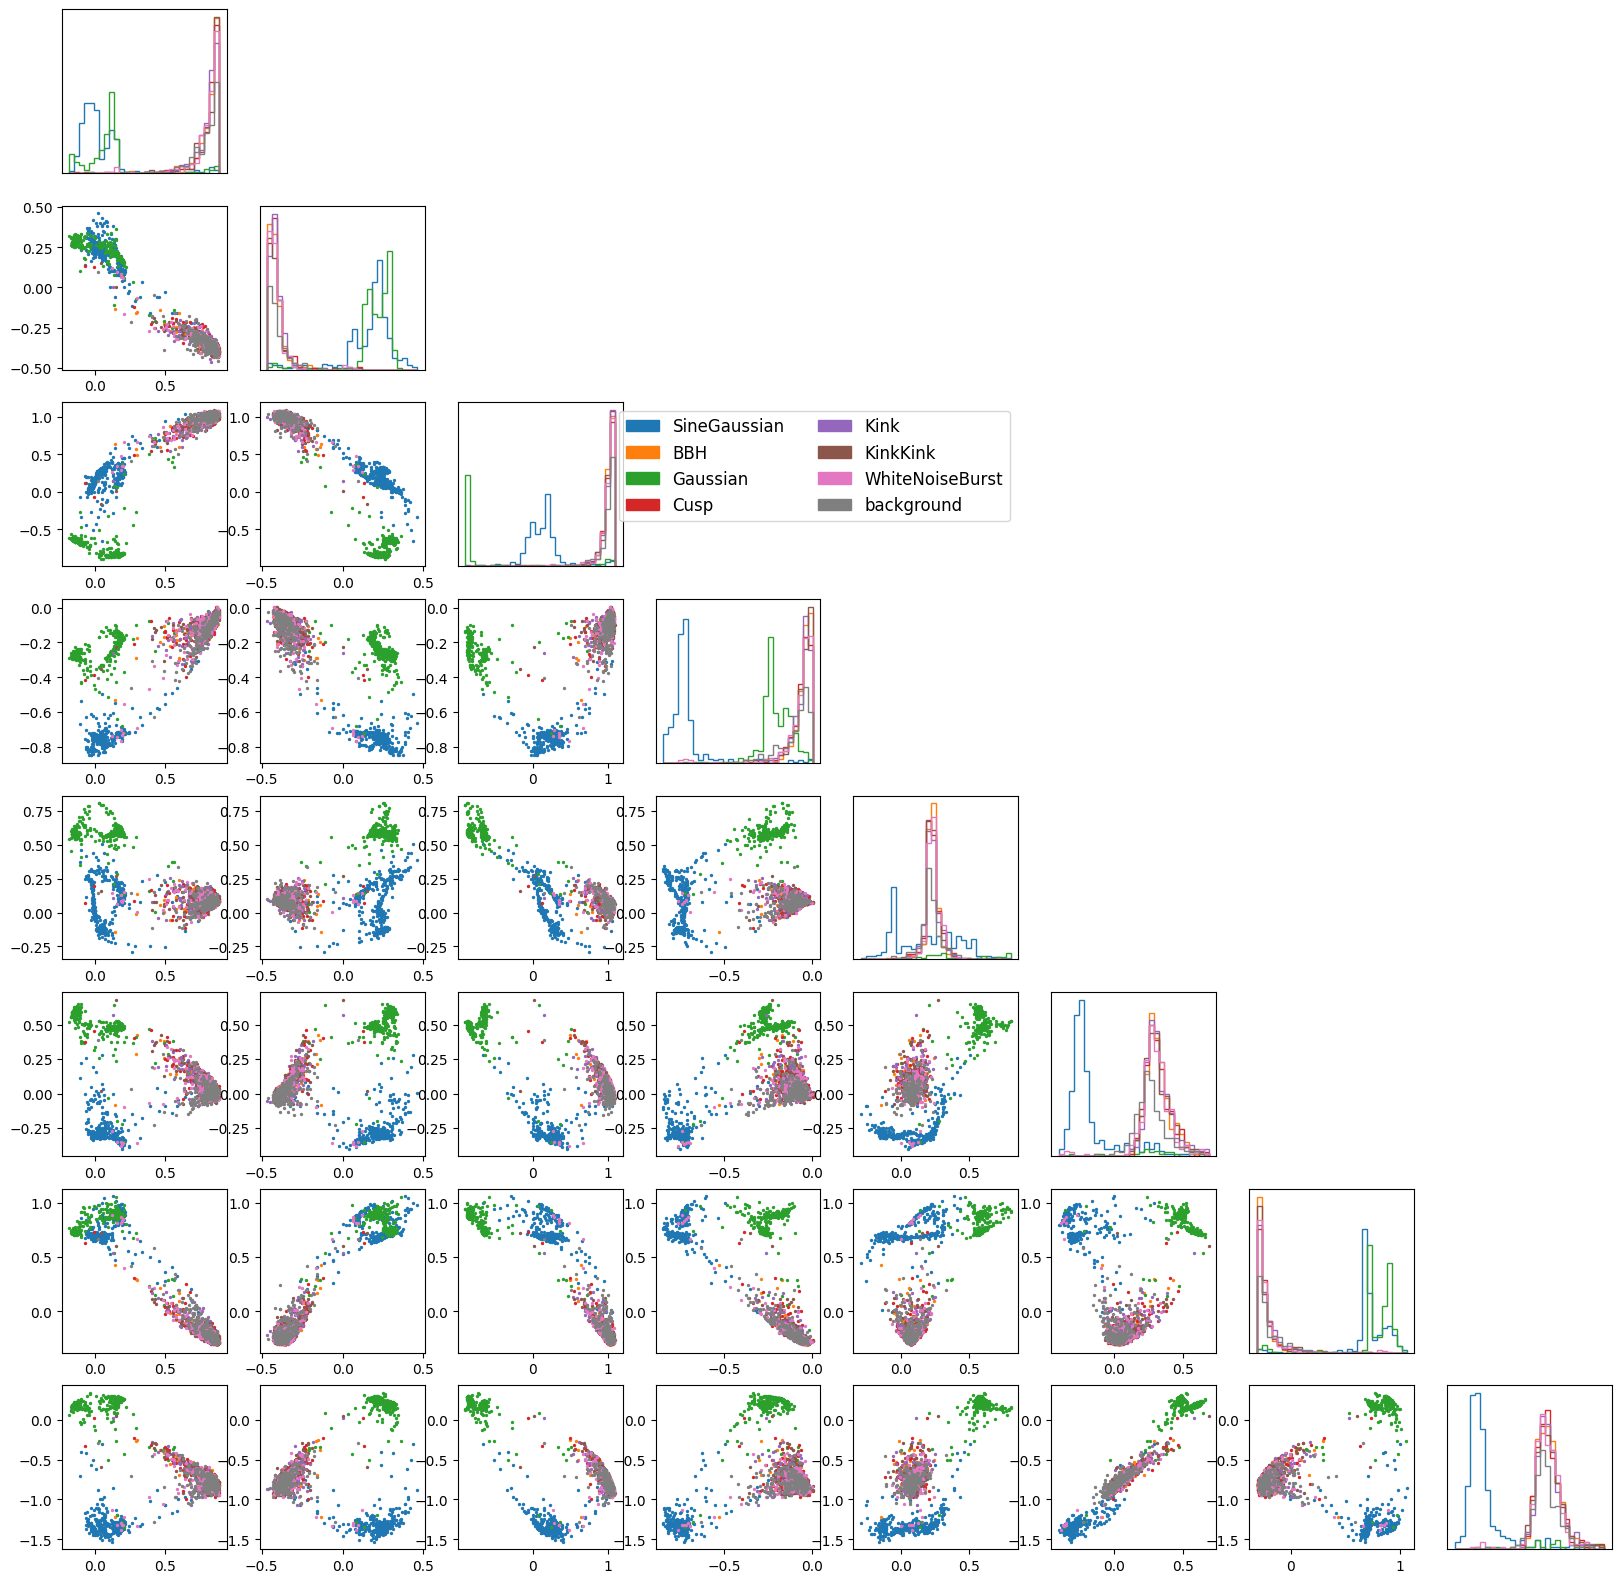

In [15]:
#import corner

N = y.shape[1]
labs_uniq = sorted(list(set(l)))
fig,axes = plt.subplots(N,N,figsize=(20,20))

for i in range(y.shape[1]):
    for j in range(i+1,y.shape[1]):
        plt.sca(axes[i,j])
        plt.axis('off')

for i in range(y.shape[1]):
    plt.sca(axes[i,i])
    plt.xticks([])
    plt.yticks([])
    bins = 30
    for j,lab in enumerate(labs_uniq):
        h,bins,_ = plt.hist(y[l==lab][:,i],bins=bins,histtype='step',color=f"C{j}")
        
for i in range(1,y.shape[1]):
    for j in range(i):
        plt.sca(axes[i,j])
        # plt.xticks([])
        # plt.yticks([])
        for k,lab in enumerate(labs_uniq):
            ysel = y[l==lab]
            plt.scatter(ysel[:,j],ysel[:,i],s=2,color=f"C{k}")
            
from matplotlib.patches import Patch
plt.sca(axes[2,4])
patches = []
for k,lab in enumerate(labs_uniq):
    patches.append(Patch(color=f"C{k}",label=signal_classes[k]))
plt.legend(handles=patches,ncol=2,fontsize=12)
plt.savefig('with_background.pdf')
#for i,lab in enumerate(sorted(list(set(l)))):
#    corner.corner(y[l==lab],fig=fig,color=f"C{i}")

In [16]:
y.shape

(2816, 8)